# Texture Synthesis

Vivek Kwatra, Irfan Essa, Aaron Bobick, and Nipun Kwatra. 2005.
Texture optimization for example-based synthesis. ACM Trans. Graph. 24, 3 (July 2005), 795–802.
https://doi.org/10.1145/1073204.1073263

Copyright © 2005 by the Association for Computing Machinery, Inc

```
This is a Python implementation of Algorithm 1 in the paper above.
Code is my own work, but the idea is from the paper.
```

texture image size is (64, 64, 3)


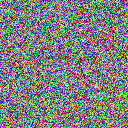

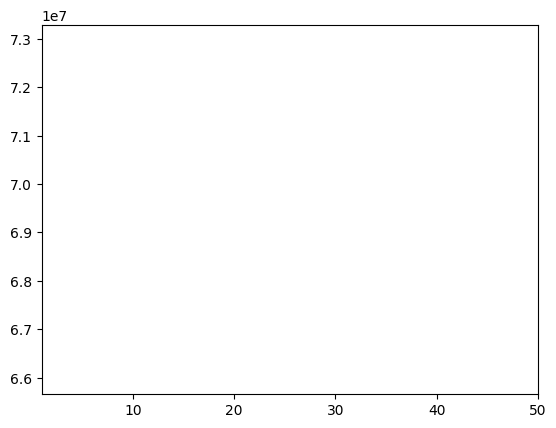

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [10]:
from datetime import datetime

import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from PIL import Image


### variables
path_to_texture_img = "sample_images/161.jpg"
target_width = 128
neighbor_width = 16
max_iter = 50


texture = cv2.imread(path_to_texture_img)
print("texture image size is", texture.shape)

target = np.random.randint(0, 256, size=(target_width, target_width, 3), dtype=np.uint8)
img_display = display(Image.fromarray(target), display_id=True)

indices = np.arange(0, target_width - neighbor_width + 1, neighbor_width // 4)
x, y = np.meshgrid(indices, indices)
target_anchors = np.column_stack((y.ravel(), x.ravel()))

texture_anchors = np.zeros((len(target_anchors), 2), dtype=int)
texture_anchors[:, 0] = np.random.randint(
    0, texture.shape[0] - neighbor_width, size=len(target_anchors)
)
texture_anchors[:, 1] = np.random.randint(
    0, texture.shape[1] - neighbor_width, size=len(target_anchors)
)


loss_history = []

for iter in range(max_iter):
    # update target to argmin(E(target, texture))
    ref_for_pixel = [[] for _ in range(target_width**2)]

    for target_anchor, texture_anchor in zip(target_anchors, texture_anchors):
        y, x = target_anchor
        yy, xx = texture_anchor
        for i in range(neighbor_width):
            for j in range(neighbor_width):
                ref_for_pixel[(y + i) * target_width + (x + j)].append(
                    texture[yy + i, xx + j]
                )

    loss = 0
    for y in range(len(target)):
        for x in range(len(target)):
            target[y, x] = np.mean(ref_for_pixel[y * target_width + x], axis=0)
            loss += np.sum((ref_for_pixel[y * target_width + x] - target[y, x]) ** 2)

    print(f"iter {iter+1}: loss:{loss}")
    loss_history.append(loss)
    img_display.update(Image.fromarray(target))

    # update texture reference points
    texture_anchors_prev = texture_anchors.copy()

    for i, target_anchor in enumerate(target_anchors):
        y, x = target_anchor
        result = cv2.matchTemplate(
            texture,
            target[y : y + neighbor_width, x : x + neighbor_width, :],
            method=cv2.TM_SQDIFF,
        )
        _, _, _, max_loc = cv2.minMaxLoc(result)
        texture_anchors[i] = np.array([max_loc[1], max_loc[0]])

    if np.all(texture_anchors == texture_anchors_prev):
        break


display(Image.fromarray(target))

now = datetime.now()
now = now.strftime("%Y%m%d%H%M%S")
Image.fromarray(target).save(f"synthesized_texture{now}.png")

plt.plot(range(1, len(loss_history) + 1), loss_history, "ro-")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.title("loss history")
plt.show()